In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import pickle

In [73]:
# Save the model to a file
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Load the model from a file
def load_model(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

# Function to encode features using saved classes and handle unknown values
def encode_feature(feature_series, encoder_classes, unknown_value='Unknown'):
    le = LabelEncoder()
    le.classes_ = np.concatenate([encoder_classes, [unknown_value]])
    encoded = feature_series.map(lambda x: x if x in encoder_classes else unknown_value)
    return le.transform(encoded)

# Function to preprocess the data (handles missing values, encoding, normalization, and SMOTE)
def preprocess_data(X, y=None, test=False):
    # Handle missing values
    X = X.fillna('Unknown')

    # Encode categorical variables and save the encoders
    le_dict = {}
    for feature in X.columns:
        if X[feature].dtype == 'object':
            le = LabelEncoder()
            X[feature] = le.fit_transform(X[feature])
            if not test:  # Save encoder only when not in test mode
                np.save(f'{feature}_encoder_classes.npy', le.classes_)
            le_dict[feature] = le

    # Normalize numerical features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # Handle class imbalance with SMOTE (for training only)
    if y is not None and not test:
        smote = SMOTE(k_neighbors=2, random_state=42)
        X, y = smote.fit_resample(X, y)
        print(f"After SMOTE: X shape = {X.shape}, y shape = {y.shape}")  # Debugging step to check dimensions
    
    return X, y, le_dict, scaler

# Function to encode the target variable and save encoder
def encode_target(y, test=False):
    le_target = LabelEncoder()
    if not test:
        y = le_target.fit_transform(y)
        np.save('target_status_classes.npy', le_target.classes_)
    else:
        encoder_classes = np.load('target_status_classes.npy', allow_pickle=True)
        le_target.classes_ = encoder_classes
        y = le_target.transform(y)
    return y, le_target

In [74]:
# Load the dataset
df = pd.read_csv("train.csv")
print(df['Target_Status'].value_counts())

Target_Status
Approved                           31031
Phase 2                            29621
Phase 1                            16912
Phase 3                            15514
Investigative                       9174
Phase 1/2                           6160
Discontinued in Phase 2             5815
Terminated                          5234
Patented                            3055
Discontinued in Phase 3             2510
Discontinued in Phase 1             2379
Preclinical                         1978
Withdrawn from market               1519
Phase 2/3                           1432
Phase 4                              507
Clinical trial                       348
Preregistration                      228
Phase 1b                             157
Phase 2a                             135
Discontinued in Preregistration      131
Discontinued in Phase 1/2            129
Registered                           121
Approved (orphan drug)               105
Application submitted                 80
IN

In [75]:
df['Drug_high_status'].unique()
df['Drug_high_status'] = df['Drug_high_status'].replace('approved', 'Approved')

In [76]:
# Remove unwanted columns
columns_to_remove = ['ID', 'TargetID', 'DRUGID', 'PUBCHCID', 'UNIPROID', 'SYNONYMS', 
                     'FUNCTION', 'SEQUENCE', 'Accession Number']
df.drop(columns=columns_to_remove, inplace=True)

In [77]:
# Select the features and target (excluding DRUGTYPE and Drug_Status)
features = ['DRUGNAME', 'Disease_of_highest_status', 'TARGNAME', 'GENENAME', 'BIOCLASS', 'Disease']
X = df[features].copy()  
y = df['Target_Status'].copy()

# Preprocess the training data
X, y_encoded, le_dict, scaler = preprocess_data(X, y)
y_encoded, le_target = encode_target(y_encoded)

# Check if X and y_encoded have the same number of rows
print(f"X shape: {X.shape}, y_encoded shape: {y_encoded.shape}") 

After SMOTE: X shape = (1024023, 6), y shape = (1024023,)
X shape: (1024023, 6), y_encoded shape: (1024023,)


In [78]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=42)


print(f"Training set shapes: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Test set shapes: X_test = {X_test.shape}, y_test = {y_test.shape}")

Training set shapes: X_train = (686095, 6), y_train = (686095,)
Test set shapes: X_test = (337928, 6), y_test = (337928,)


In [79]:
# 1. Decision Tree Classifier with Grid Search for Hyperparameter Tuning
dt_classifier = DecisionTreeClassifier(random_state=42)

# Define the parameter grid to search over for Decision Tree
dt_param_grid = {
    'criterion':  ['entropy'],          
    'max_depth': [None],                
    'min_samples_split': [2, 10],       
    'min_samples_leaf': [1, 5, 10],     
    'max_features': [None]              
}

# Initialize GridSearchCV for Decision Tree
dt_grid_search = GridSearchCV(estimator=dt_classifier, param_grid=dt_param_grid, 
                              scoring='accuracy', n_jobs=-1, verbose=1)

# Train the classifier using grid search
dt_grid_search.fit(X_train, y_train)

# Get the best parameters and classifier for Decision Tree
best_dt_params = dt_grid_search.best_params_
best_dt_classifier = dt_grid_search.best_estimator_

# Make predictions on the test data using the best Decision Tree classifier
y_dt_pred = best_dt_classifier.predict(X_test)

# Evaluate Decision Tree classifier
dt_accuracy = accuracy_score(y_test, y_dt_pred)
print(f"Best Decision Tree Parameters: {best_dt_params}")
print(f"Decision Tree Accuracy: {dt_accuracy * 100:.2f}%")
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_dt_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Accuracy: 99.22%

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10386
           1       0.98      0.99      0.99     10194
           2       1.00      1.00      1.00     10257
           3       1.00      1.00      1.00     10334
           4       1.00      1.00      1.00     10313
           5       0.99      0.99      0.99     10180
           6       1.00      1.00      1.00     10126
           7       0.98      0.98      0.98     10234
           8       1.00      1.00      1.00     10213
           9       1.00      1.00      1.00     10477
          10       0.99      0.99      0.99     10253
          11       1.00      1.00      1.00     10141
          12       1.00 

In [80]:
best_classifier = best_dt_classifier
y_pred = y_dt_pred

# Evaluate the best model
best_accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest Model Accuracy: {best_accuracy * 100:.4f}%")
print("\nBest Model Classification Report:")
print(classification_report(y_test, y_pred))



Best Model Accuracy: 99.2232%

Best Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10386
           1       0.98      0.99      0.99     10194
           2       1.00      1.00      1.00     10257
           3       1.00      1.00      1.00     10334
           4       1.00      1.00      1.00     10313
           5       0.99      0.99      0.99     10180
           6       1.00      1.00      1.00     10126
           7       0.98      0.98      0.98     10234
           8       1.00      1.00      1.00     10213
           9       1.00      1.00      1.00     10477
          10       0.99      0.99      0.99     10253
          11       1.00      1.00      1.00     10141
          12       1.00      1.00      1.00     10213
          13       1.00      1.00      1.00     10123
          14       0.97      0.97      0.97     10121
          15       0.99      0.99      0.99     10281
          16   

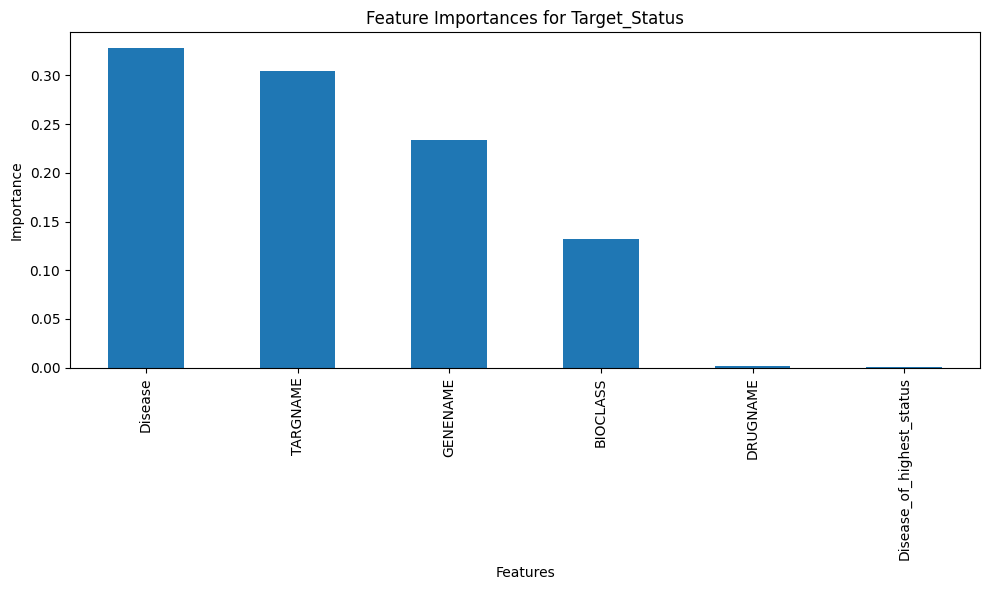

In [81]:
importances = pd.Series(best_classifier.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('Feature Importances for Target_Status')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [82]:
# Load and preprocess the test dataset
test_df = pd.read_csv("test.csv")
X_test = test_df[features].copy()

# Encode the test dataset using the saved encoders
for feature in features:
    if X_test[feature].dtype == 'object':
        encoder_classes = np.load(f'{feature}_encoder_classes.npy', allow_pickle=True)
        X_test[feature] = encode_feature(X_test[feature], encoder_classes)

# Scale the test data using the scaler fitted on the training data
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Make predictions on the test set
y_pred_encoded = best_classifier.predict(X_test)

# Decode the predictions back to original labels
y_pred = le_target.inverse_transform(y_pred_encoded)

# Create submission DataFrame
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'Prediction': y_pred
})

In [83]:
# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

# Display the first few rows of the submission file
print("\nFirst few rows of the submission file:")
print(submission.head())

# Check for missing values
print("\nMissing values in submission file:")
print(submission.isnull().sum())

Submission file created: submission.csv

First few rows of the submission file:
       ID Prediction
0    1076   Approved
1  190816    Phase 3
2  180551    Phase 3
3   51630   Approved
4   50566  Phase 1/2

Missing values in submission file:
ID            0
Prediction    0
dtype: int64
